<img src="https://i.imgur.com/12tfKrD.png" alt="Alin">
</img>


# Demo RNN -- 張愛玲散文集AI二次創作

資料集: 張愛玲繁體中文小說 《傳奇》

爬蟲來源: [crawl_book](https://colab.research.google.com/drive/1f_HvQEvgkJPFc473TlA-I_3EmkThA2SR?usp=sharing)

程式碼參考: [Tensorflow](https://www.tensorflow.org/tutorials/text/text_generation)

本次資料集，著作權乃是張愛玲女士所擁有。**請勿將本次資料集散播、更改、用於非商業用途**。

> **資料集說明**

今年是張愛玲女士101年誕辰。張愛玲出生名門，曾就讀於香港大學和聖約翰大學，受過良好的中西教育。上海淪陷時期，陸續發表《沉香屑·第一爐香》、《傾城之戀》、《心經》、《金鎖記》等中、短篇小說，震動上海文壇。

這次訓練取張愛玲散文集《傳奇》作為訓練，《傳奇》收留五篇散文: 「留情」、「鴻鸞禧」、「紅玫瑰與白玫瑰」、「等」、「桂花蒸阿小悲秋」。其中以「紅玫瑰與白玫瑰」最為膾炙人口。

> **訓練步驟**

深度學習在訓練模型上有以下幾個重要的步驟:
1. 讀入相關封包
2. 取得資料集 
3. 資料前處理
4. 建立模型
5. 制定訓練計畫
6. 評估模型
7. 做預測

> **本次模型介紹 RNN**

![](https://i.imgur.com/FaY50C8.png)


我們來看看維度，很多人會搞不懂RNN的維度:

一個Seq通過RNN後的維度

* Input: (Seq,${originDim}$)
* RNN Neuron: 2048
* Output: (Seq,2048) if (return_sequence == True) else (1,2048)
![](https://i.imgur.com/9SVl6JR.png)

![](https://i.imgur.com/z4ElFIr.png)

**把生成問題變成分類問題**

![](https://i.imgur.com/TBHKuf6.png)


In [ ]:
# ****************************************
# **請勿將本次資料集散播、用於非商業用途**
# ****************************************

# 執行即代表同意將會合法、合理使用資料集

!wget -O Eileen_Legendary.txt "http://140.115.82.54/NN/Recurrent/Eileen_Legendary.txt"

--2021-04-12 02:33:26--  http://140.115.82.54/NN/Recurrent/Eileen_Legendary.txt
Connecting to 140.115.82.54:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 818352 (799K) [text/plain]
Saving to: ‘Eileen_Legendary.txt’

Eileen_Legendary.tx 100%[===================>] 799.17K   304KB/s    in 2.6s    

2021-04-12 02:33:29 (304 KB/s) - ‘Eileen_Legendary.txt’ saved [818352/818352]



## 1. 讀入Package

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt

## 2. 取得資料集

In [ ]:
# 作業之一就是試試看其他本小說

book = ""
with open("./Eileen_Legendary.txt","r",encoding="utf8") as file:
  for line in file:
    book += line

book_length = len(book)
unique_words = set(book)
print(f"張愛玲散文集共有 {book_length} 字詞")
print(f"包含了 {len(unique_words)} 個獨一無二的字 (含標點符號)\n")
print(book[0:500])

張愛玲散文集共有 274000 字詞
包含了 3665 個獨一無二的字 (含標點符號)

我自己從來沒想到需要辯白，但最近一年來常常被人議論到，似乎被列為文化漢奸之一，自己也弄得莫名其妙。我所寫的文章從來沒有涉及政治，也沒有拿過任何津貼。想想看我唯一的嫌疑要末就是所謂「大東亞文學者大會」第三屆曾經叫我參加，報上登出的名單內有我；雖然我寫了辭函去，（那封信我還記得，因為很短，僅只是：「承聘為第三屆大東亞文學者大會代表，謹辭。張愛玲謹上。」）報上仍舊沒有把名字去掉。
至於還有許多無稽的謾罵，甚而涉及我的私生活，可以辯駁之點本來非常多。而且即使有這種事實，也還牽涉不到我是否有漢奸嫌疑的問題；何況私人的事本來用不著向大眾剖白，除了對自己家的家長之外彷彿我沒有解釋的義務。所以一直緘默著。同時我也實在不願意耗費時間與精神去打筆墨官司，徒然攪亂心思，耽誤了正當的工作。但一直這樣沉默著，始終沒有闡明我的地位，給社會上一個錯誤的印象，我也覺得是對不起關心我的前途的人。所以在小說集重印的時候寫了這樣一段作為序。反正只要讀者知道了就是了。
※※※
《傳奇》裏面新收進的五篇，「留情」、「鴻鸞禧」、「紅玫瑰與白玫瑰」、「等」、「桂花蒸阿小悲秋」，初發表的時候有許多草率的地方，實在對讀者感到抱歉，這次


## 3. 資料前處理

文字前處理有一堆方法、作法:
* 切字
* 還原
* 清除特殊字符
* 清除不常見字符 (StopWord)


我這裡僅使用去除不常見的字(StopWord)

In [ ]:
# 計算字數統計
words_count = {}
for w in book:
  if w in words_count:
    words_count[w] += 1
  else:
    words_count[w] = 1

words_count = sorted(words_count.items(),key=lambda x:x[1])

In [ ]:
stop_word = 8
unique_words = [w_tup[0] for w_tup in words_count if w_tup[1]>stop_word]
print(f"去除次數小於{stop_word}的文字剩餘 : {len(unique_words)}")

去除次數小於8的文字剩餘 : 1973


In [ ]:
print(f"原本張愛玲散文集共有 {book_length} 字詞")
print(f"去除不常出現的文字後")
book = [w for w in book if w in unique_words]
print(f"剩餘{len(book)}個字")

原本張愛玲散文集共有 274000 字詞
去除不常出現的文字後
剩餘268660個字


In [ ]:
# 文字轉數字(index)
word_2_index = {word:index for index,word in enumerate(unique_words)}
index_2_word = {word_2_index[word]:word for word in word_2_index}

book_2_index = [word_2_index[w] for w in book]

print("原始文字 : ")
print(book[:40])
print("-"*40)
print("轉成index : ")
print({word_2_index[w] for w in book[:40]})

原始文字 : 
['我', '自', '己', '從', '來', '沒', '想', '到', '需', '要', '辯', '白', '，', '但', '最', '近', '一', '年', '來', '常', '常', '被', '人', '議', '論', '到', '，', '似', '乎', '被', '列', '為', '文', '化', '漢', '之', '一', '，', '自', '己']
----------------------------------------
轉成index : 
{1921, 1540, 1799, 1929, 1937, 659, 1428, 1558, 1053, 1954, 1955, 1188, 1958, 1968, 178, 1972, 1854, 1730, 1731, 1618, 1876, 1885, 1890, 1891, 1636, 99, 614, 1646, 1905, 1907, 1781}


In [ ]:
def ind2word_seq(seq):
  return [index_2_word[i] for i in seq]

In [ ]:
# 設定輸入模型長度
seq_len = 20
characters = tf.data.Dataset.from_tensor_slices(book_2_index)
# characters = characters.map(lambda w:word_2_index[w.item()])

sequences = characters.batch(seq_len+1,drop_remainder=True)

for seq in sequences.take(2):
  print(seq.shape)
  print(seq)
  print([index_2_word[i] for i in seq.numpy()])

(21,)
tf.Tensor(
[1954 1907 1876 1854 1958 1929 1890 1937  659 1921  614 1891 1972 1730
 1636 1558 1968 1885 1958 1731 1731], shape=(21,), dtype=int32)
['我', '自', '己', '從', '來', '沒', '想', '到', '需', '要', '辯', '白', '，', '但', '最', '近', '一', '年', '來', '常', '常']
(21,)
tf.Tensor(
[1646 1955 1053 1428 1937 1972 1799 1540 1646   99 1905 1618 1188  178
 1781 1968 1972 1907 1876 1942 1470], shape=(21,), dtype=int32)
['被', '人', '議', '論', '到', '，', '似', '乎', '被', '列', '為', '文', '化', '漢', '之', '一', '，', '自', '己', '也', '弄']


![](https://i.imgur.com/YMVMFEJ.png)


In [ ]:
# 做input、target切割
def split_input_target(seq):
  input_txt = seq[:-1]
  target_txt = seq[1:]
  return input_txt,target_txt

split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

![](https://i.imgur.com/YoHWLkf.png)


In [ ]:
dataset = sequences.map(split_input_target)

for input_example,target_exaple in dataset.take(1):
  print("Input :", ind2word_seq(input_example.numpy()))
  print("Target:", ind2word_seq(target_exaple.numpy()))
  print("-"*50)
  print("Input :", input_example.numpy())
  print("Target:", target_exaple.numpy())

Input : ['我', '自', '己', '從', '來', '沒', '想', '到', '需', '要', '辯', '白', '，', '但', '最', '近', '一', '年', '來', '常']
Target: ['自', '己', '從', '來', '沒', '想', '到', '需', '要', '辯', '白', '，', '但', '最', '近', '一', '年', '來', '常', '常']
--------------------------------------------------
Input : [1954 1907 1876 1854 1958 1929 1890 1937  659 1921  614 1891 1972 1730
 1636 1558 1968 1885 1958 1731]
Target: [1907 1876 1854 1958 1929 1890 1937  659 1921  614 1891 1972 1730 1636
 1558 1968 1885 1958 1731 1731]


In [ ]:
# 建立資料集
# Batch size
BATCH_SIZE = 64

BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True))

dataset

<BatchDataset shapes: ((64, 20), (64, 20)), types: (tf.int32, tf.int32)>

## 4. 建立模型

![](https://i.imgur.com/TBHKuf6.png)

In [ ]:
# 超參數
EMBEDDING_DIM = 512

# 使用 keras 建立一個非常簡單的 LSTM 模型
model = tf.keras.Sequential()

model.add(
  tf.keras.layers.Embedding(
    input_dim=len(unique_words), 
    output_dim=EMBEDDING_DIM
))

model.add(
  tf.keras.layers.LSTM(
    units=4096, 
    return_sequences=True, 
))

model.add(
  tf.keras.layers.LSTM(
    units=2048, 
    return_sequences=True,
))
  
model.add(
  tf.keras.layers.Dense(
      len(unique_words),activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 512)         1010176   
_________________________________________________________________
lstm (LSTM)                  (None, None, 4096)        75513856  
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 2048)        50339840  
_________________________________________________________________
dense (Dense)                (None, None, 1973)        4042677   
Total params: 130,906,549
Trainable params: 130,906,549
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 查看模型的輸入、輸出 shape
for input_example,target_exaple in dataset.take(1):
  predict_example = model(input_example)
  print(f"Model input shape : {input_example.shape}")
  print(f"Model output shape : {predict_example.shape}")
  print(f"Model target shape : {target_exaple.shape}")

Model input shape : (64, 20)
Model output shape : (64, 20, 1973)
Model target shape : (64, 20)


In [ ]:
print("原本的中文字序列：")
[print(index_2_word[ind],end="") for ind in input_example[0].numpy()]
print()
print("-"*40)
print("輸入尚未訓練的model後獲得：")
print()

predict_words = tf.math.argmax(predict_example[0],-1)
[print(index_2_word[ind],end="") for ind in predict_words.numpy()]
print()

原本的中文字序列：
太微笑著，並不和他辯，自顧自喚阿媽取過碗
----------------------------------------
輸入尚未訓練的model後獲得：

哄珠星捨捨帳帳吊吊吊吊吊吊吊吊吊香香撲羊


## 5. 制定訓練計畫並訓練

* [sparse_categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) V.S. [categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy)

```python=
# categorical_crossentropy
y_true = [[0, 1, 0], [0, 0, 1]]
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
assert loss.shape == (2,)

# sparse_categorical_crossentropy
y_true = [1, 2]
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
assert loss.shape == (2,)

```


In [ ]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam")

In [ ]:
EPOCHS = 20
history = model.fit(
    dataset, # 前面使用 tf.data 建構的資料集
    epochs=EPOCHS,
)

Epoch 1/20
199/199 [==============================] - 77s 377ms/step - loss: 6.3566
Epoch 2/20
199/199 [==============================] - 75s 376ms/step - loss: 5.4032
Epoch 3/20
199/199 [==============================] - 75s 375ms/step - loss: 4.8969
Epoch 4/20
199/199 [==============================] - 75s 377ms/step - loss: 4.5331
Epoch 5/20
199/199 [==============================] - 75s 378ms/step - loss: 4.2807
Epoch 6/20
199/199 [==============================] - 76s 378ms/step - loss: 4.0603
Epoch 7/20
199/199 [==============================] - 75s 378ms/step - loss: 3.8509
Epoch 8/20
199/199 [==============================] - 75s 378ms/step - loss: 3.6136
Epoch 9/20
199/199 [==============================] - 75s 378ms/step - loss: 3.3549
Epoch 10/20
199/199 [==============================] - 76s 379ms/step - loss: 3.0634
Epoch 11/20
199/199 [==============================] - 76s 378ms/step - loss: 2.7200
Epoch 12/20
199/199 [==============================] - 75s 378ms/step - lo

## 6. 衡量模型

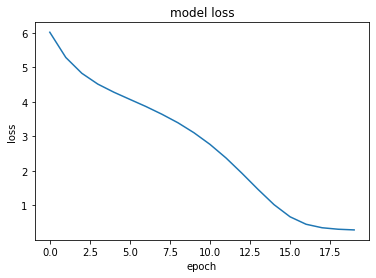

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [ ]:
after_train_predictions = model(input_example)
after_sampled_indices = tf.argmax(after_train_predictions[0],1)

print("原本的中文字序列：")
[print(index_2_word[ind],end="") for ind in input_example[0].numpy()]
print()
print("-"*40)
print("輸入進訓練後的model後獲得：")
print()

[print(index_2_word[ind],end="") for ind in after_sampled_indices.numpy()]
print()

原本的中文字序列：
太微笑著，並不和他辯，自顧自喚阿媽取過碗
----------------------------------------
輸入進訓練後的model後獲得：

太笑著，並不和他辯，自顧自喚阿媽取過碗櫥


## 7. 做預測

![](https://i.imgur.com/YsOj6Mw.png)

在實際生成文字時，我們會想要增加一些隨機性。比如”天天出去” 不加入隨機 “天天天天” 如果我們全部輸出的字都是取softmax最大可能性，則一個訓練完美的model會把整本書給輸出出來。但是我們要的是，希望電腦在最大可能性的幾個字中隨機挑選一個字出來。

tf.random.categorical 會根據softmax機率後隨機挑選字，但是我們不希望因為模型很爛導致不合理的字被選中，因此我們會除上一個temperature來增加可能字的比重。

EX: "天天出去" 預測下一個字
1. 玩 : 0.3 
2. 天 : 0.1 
3. 浪 : 0.4 

"天"有的機率被印出，我們不希望。所以我們可以在每一個機率除上一個temperature(0.01)
1. 玩 : 30 
2. 天 : 10 
3. 浪 : 40 
原本"浪"跟"天"差0.3，除temperature後差30



In [ ]:
# 預測文字，並把預測文字循環當作下一次的輸入

# 設定你的temperature
temperature = 0.01

def generateWords(input,words=500):
  [print(index_2_word[ind],end="") for ind in input]
  for i in range(words):
    next_input = tf.expand_dims(input,axis=0)
    predicts = model(next_input)
    predicts = predicts[:,-1,:]
    predicts /= temperature
    result = tf.random.categorical(
        predicts,num_samples=1
    )
    chinese_ind = tf.squeeze(result).numpy()
    print(index_2_word[chinese_ind],end="")
    input = input+[chinese_ind]
    input = input[-seq_len:]

In [ ]:
init_seq = "紅玫瑰"
init_seq_ind = [word_2_index[w] for w in init_seq]
input = init_seq_ind[-seq_len:]

generateWords(input,500)

他心裏的一跳，彷彿十年前的事又多死了，然而三十年前……那是最可以的事。」流蘇道：「那怕不行。我不能夠離婚。我們那邊的愛，是不完全的。你母親……」世舫站定了腳。
隔了一會，問道：「你這樣的就吃了，玩也玩不成？」
話心說：「唔，唔，」地叫：「哥兒達先生，你很少說話。」雲藩笑道：「你這不是鬧著的時候，你再要把它跟了出來，讓她們見過了，是不成的親戚，她一定會答應他。的確，他從來沒有這麼的清醒過來，他們的同學們也沒有，惟有一個不在上面，只是一點空白，一點一點，到了夏天，只怕被他們的舍監的一個安靜的口氣。他們也許並不是悠久的無的快樂。她說：「不過他們一點兒了，」他們說：「不，讓我出去罷！」
宗楨道：「我不能夠離婚。我們那時候，如果沒讓她，他一定能夠利用這一切。
她的眼睛被他的手臂為了她的腳，直射到她的臉上。
樓上的一隻腳，劈手搭在要走了。他沒有想到沒有，只有她一個人在這兒。
他的臥室的角落裏堆�
�一隻大籐箱，裏面高高地，慌音裏彷彿一陣陰風吹過，蜜秋兒太太半晌沒有坐，在簫黑的沙發上，一陣風把所有的插戴全剝了下來，還了老太太，振保把門關在玻璃上，被紙上的簾子向後斜著一張，查不及地一下

In [ ]:
# 不要執行這一個block
import time
while True:
  time.sleep(5)
  pass

## 作業2.1 (30%)

使用[爬蟲程式](https://colab.research.google.com/drive/1f_HvQEvgkJPFc473TlA-I_3EmkThA2SR?usp=sharing)來取得一個新的文本資料集，或是不管你從哪裡取得的資料集也可以(不要再張愛玲了，不限中英文)。然後丟入這個模型來看看AI生成文字的成果，將**結果**與**你的心得**(不是機器產生的心得)，貼上pdf。

請隨意修改本colab的模型與參數來達到更好的結果。

資料集越有趣越好，比如你可以去爬PTT文章來製作廢文產生器。去爬Dcard製作幻想文產生器。